<a href="https://colab.research.google.com/github/CodyBurker/W266_Group_Project/blob/CodyCNNBase/CodyCNNAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [2]:
import pandas as pd
import string
from nltk.corpus import stopwords
import nltk
import numpy as np

In [3]:
!git clone https://github.com/CodyBurker/W266_Group_Project

Cloning into 'W266_Group_Project'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 139 (delta 57), reused 42 (delta 7), pack-reused 0
Receiving objects: 100% (139/139), 133.37 MiB | 26.77 MiB/s, done.
Resolving deltas: 100% (57/57), done.
Checking out files: 100% (20/20), done.


In [4]:
def read_in_data(path="W266_Group_Project/"):
    import pandas as pd
    X_train = pd.read_csv(path + "x_train_sampled_yelp_data.csv")
    y_train = pd.read_csv(path + "y_train_sampled_yelp_data.csv")
    X_test = pd.read_csv(path + "x_test_sampled_yelp_data.csv")
    y_test = pd.read_csv(path + "y_test_sampled_yelp_data.csv")
    return X_train, X_test, y_train, y_test

In [15]:
X_train = pd.read_csv("W266_Group_Project/x_train_stage_1_sampled_yelp_data.csv")
y_train = pd.read_csv("W266_Group_Project/y_train_stage_1_sampled_yelp_data.csv")
X_test = pd.read_csv("W266_Group_Project/x_test_sampled_yelp_data_NEW.csv")
y_test = pd.read_csv("W266_Group_Project/y_test_sampled_yelp_data_NEW.csv")
y_train = np.array(y_train.stars.astype('int')) - 1
y_test = np.array(y_test.stars.astype('int')) - 1

https://towardsdev.com/sentiment-analysis-with-cnn-using-keras-c4debff57fc5?gi=708b4ef40e2f

Encode text and pad it.

Word2Vec: https://machinelearningknowledge.ai/word2vec-in-gensim-explained-for-creating-word-embedding-models-pretrained-and-custom/

In [6]:
# from gensim.models import Word2Vec,KeyedVectors

In [22]:
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])


In [24]:
X_train['encoded'] = tokenizer.texts_to_sequences(X_train['text'])
X_test['encoded'] = tokenizer.texts_to_sequences(X_test['text'])

(array([46671., 21294.,  7147.,  2708.,  1110.,   544.,   225.,   128.,
           89.,    84.]),
 array([  1.,  98., 195., 292., 389., 486., 583., 680., 777., 874., 971.]),
 <a list of 10 Patch objects>)

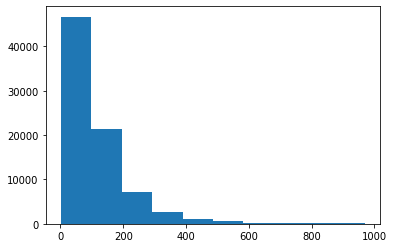

In [25]:
import matplotlib.pyplot as plt
plt.hist(X_train['encoded'].apply(len))

In [26]:
# Hyper parameters to tune later: maxlen, padding
sentence_len = 1024
X_train_encoded =  pad_sequences(X_train['encoded'], maxlen=sentence_len, padding='post', truncating='post')
X_test_encoded = pad_sequences(X_test['encoded'], maxlen=sentence_len, padding='post', truncating = 'post')
print(X_train_encoded.shape)
print(X_test_encoded.shape)

(80000, 1024)
(20000, 1024)


Create model

New Arcitecture: https://aclanthology.org/D14-1181.pdf

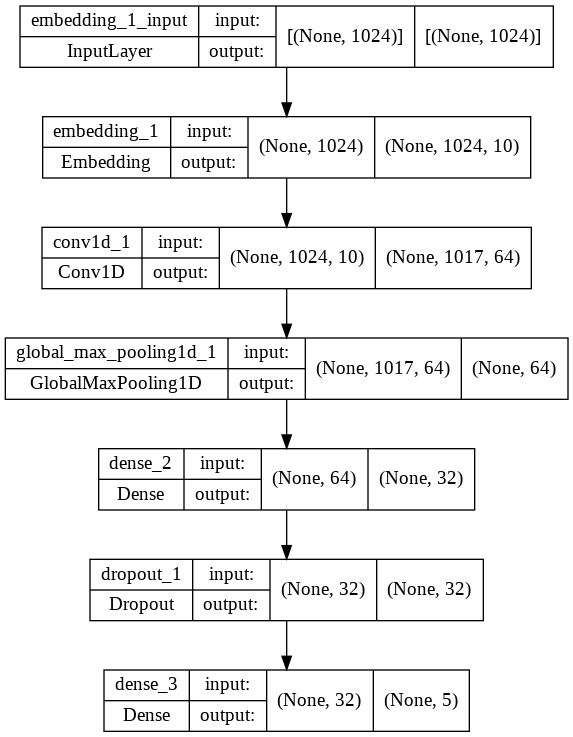

In [27]:
from keras.layers.pooling import GlobalMaxPool1D
from keras import Sequential
from keras.layers import Dense, Embedding, Activation, Dropout
from keras.layers import  MaxPool1D, GlobalMaxPool1D, Conv1D
vocab_size = len(tokenizer.word_counts)
# New model architecture
model2 = Sequential()
model2.add(Embedding(vocab_size,10, input_length = sentence_len))
model2.add(Conv1D(64,8,activation="relu"))
model2.add(GlobalMaxPool1D())
model2.add(Dense(32, activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(5,activation='softmax'))
# model2.add(Dense(1,activation='relu'))
from keras.utils.vis_utils import plot_model
model2.compile(optimizer='sgd', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model2,show_shapes=True)


In [28]:
from keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback
from keras.callbacks import ModelCheckpoint

callback = EarlyStopping(monitor='val_accuracy', patience=15)

model_checkpoint = ModelCheckpoint(
    filepath="W266_Group_Project/CNNModel/",
    monitor="val_accuracy"
)

history = model2.fit(X_train_encoded,y_train,
           epochs=150,
           batch_size=128, 
           validation_data = [X_test_encoded, y_test],
           callbacks = [TqdmCallback(verbose=0), model_checkpoint],
           verbose=0,)

0epoch [00:00, ?epoch/s]

INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Assets written to: W266_Group_Project/CNNModel/assets
INFO:tensorflow:Asse

In [37]:
from tensorflow import keras
model = keras.models.load_model('W266_Group_Project/CNNModel')
x_train_stage_2 = pd.read_csv("W266_Group_Project/x_train_stage_2_sampled_yelp_data.csv")
x_train_stage_2_tok = tokenizer.texts_to_sequences(x_train_stage_2['text'])
x_train_stage_2_enc = pad_sequences(x_train_stage_2_tok, maxlen=sentence_len, padding='post', truncating = 'post')


In [39]:
stage_2_preds = model.predict(x_train_stage_2_enc)

In [52]:
stage_2_preds[0:10]

array([[5.4550624e-11, 2.7290353e-10, 6.2589089e-07, 1.1439208e-02,
        9.8856014e-01],
       [8.0708571e-04, 1.5680771e-03, 2.1817731e-02, 2.7158141e-01,
        7.0422572e-01],
       [1.5380270e-04, 8.8425260e-04, 2.4952274e-02, 3.8962823e-01,
        5.8438146e-01],
       [2.2770471e-03, 7.5032995e-03, 8.4284164e-02, 5.0279355e-01,
        4.0314198e-01],
       [2.6345465e-04, 2.9081898e-03, 7.7292971e-02, 6.0414720e-01,
        3.1538826e-01],
       [5.8963072e-01, 3.6646354e-01, 4.3335039e-02, 5.3744600e-04,
        3.3248845e-05],
       [2.8160925e-06, 1.9348945e-06, 8.6068743e-05, 2.2147140e-02,
        9.7776204e-01],
       [5.4617547e-05, 1.1026920e-03, 4.7634207e-02, 6.1950380e-01,
        3.3170465e-01],
       [1.3328219e-05, 1.2580855e-04, 8.1185754e-03, 3.7129107e-01,
        6.2045121e-01],
       [3.8731941e-06, 8.4626707e-05, 1.0279960e-02, 4.6515608e-01,
        5.2447546e-01]], dtype=float32)

In [53]:
preds_processed = np.argmax(stage_2_preds,axis=1) +1

In [54]:
preds_processed[0:10]

array([5, 5, 5, 4, 4, 1, 5, 4, 5, 5])

In [56]:
# Write processed preds to disk
pd.DataFrame({'CNN_predictions':preds_processed}).to_csv("W266_Group_Project/CNN_Predictions.csv")

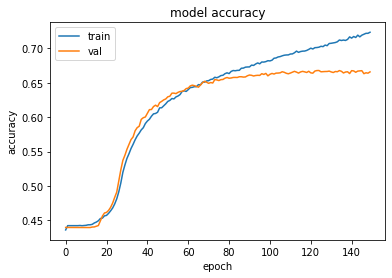

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Generate confusion matrix on test set
test_preds = model2.predict(X_test_encoded)
test_preds_stars = test_preds.argmax(axis=1) + 1
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test + 1, test_preds_stars)
import seaborn as sns
sns.heatmap(cf)